In [15]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!kaggle datasets download -d shobithparipalli/ship-images
!unzip /content/eye-diseases-classification.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ship-images.zip: Skipping, found more recently modified local copy (use --force to force download)
unzip:  cannot find or open /content/eye-diseases-classification.zip, /content/eye-diseases-classification.zip.zip or /content/eye-diseases-classification.zip.ZIP.


In [21]:
!unzip /content/ship-images.zip

Archive:  /content/ship-images.zip
replace Dataset/Cargo/2778062.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv(r"C:\Users\shobi\OneDrive\Desktop\Ship Classification\Dataset\Train\train.csv")
df.head()
ship = {1:"Cargo",2:"Military",3:"Carrier",4:"Cruise",5:"Tankers"}
df["ship"] = df["category"].map(ship).astype('category')
df.head()
classes = list(ship.values())
import os
for i in classes:
    os.makedirs(os.path.join("C:/Users/shobi/OneDrive/Desktop/Ship Classification/Dataset/Train",i))
labels = df.sort_values('ship')

import shutil
for c in classes:
    for i in list(labels[labels['ship']==c]['image']):
        image = os.path.join("C:/Users/shobi/OneDrive/Desktop/Ship Classification/Dataset/Train/images",i)
        move = shutil.move(image,"C:/Users/shobi/OneDrive/Desktop/Ship Classification/Dataset/Train/"+c)

In [17]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)
train_batch = train_gen.flow_from_directory(
    directory="/content/Dataset",
    target_size=(300, 300),
    batch_size=64,
    subset='training',
    class_mode = 'categorical',
    seed=64
)
valid_batch = train_gen.flow_from_directory(
    directory="/content/Dataset",
    target_size=(300, 300),
    batch_size=64,
    subset='validation',
    class_mode = 'categorical',
    seed=64
)

Found 5003 images belonging to 5 classes.
Found 1249 images belonging to 5 classes.


In [19]:
import matplotlib.pyplot as plt

# Function to plot images from a batch generator in a grid
def plot_images_in_grid(generator, num_images=12, num_columns=4):
    classes = list(generator.class_indices.keys())
    num_rows = num_images // num_columns

    plt.figure(figsize=(10,10))

    for i in range(num_images):
        batch = generator.next()
        images, labels = batch
        plt.subplot(num_rows, num_columns, i + 1)
        plt.imshow(images[0])
        plt.title(f"Class: {classes[int(labels[0].argmax())]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


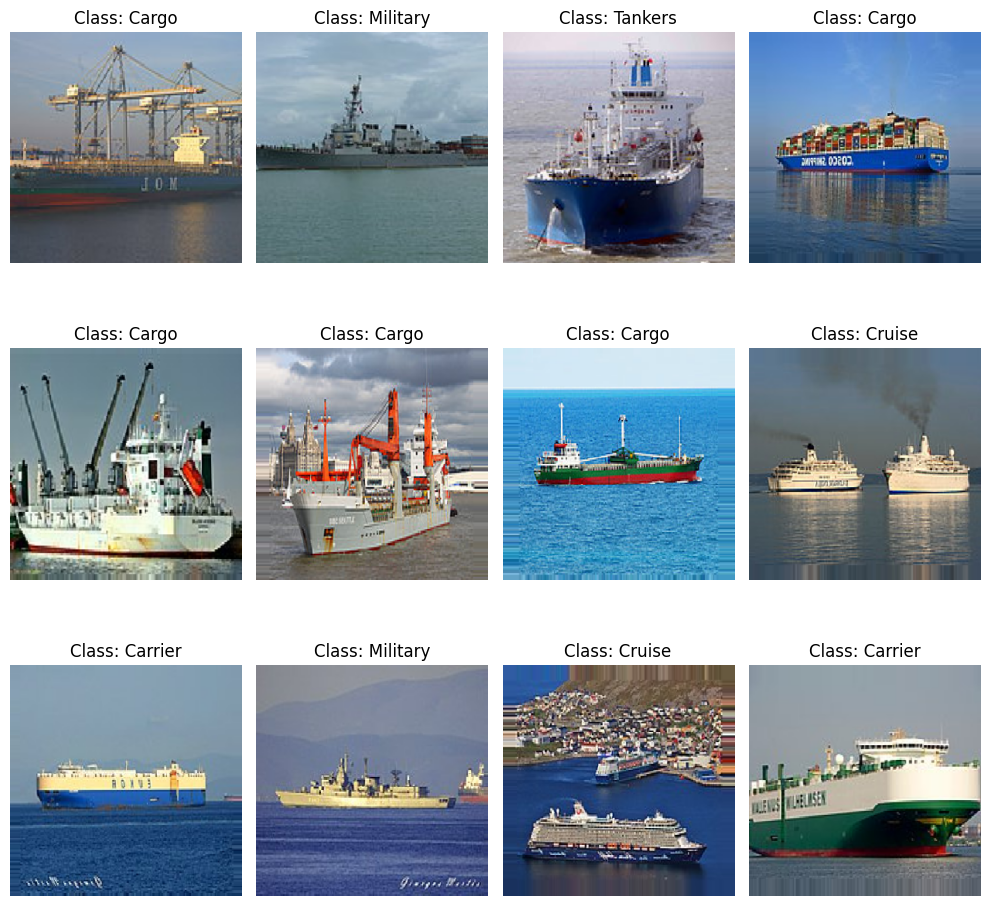

In [20]:
plot_images_in_grid(train_batch, num_images=12, num_columns=4)


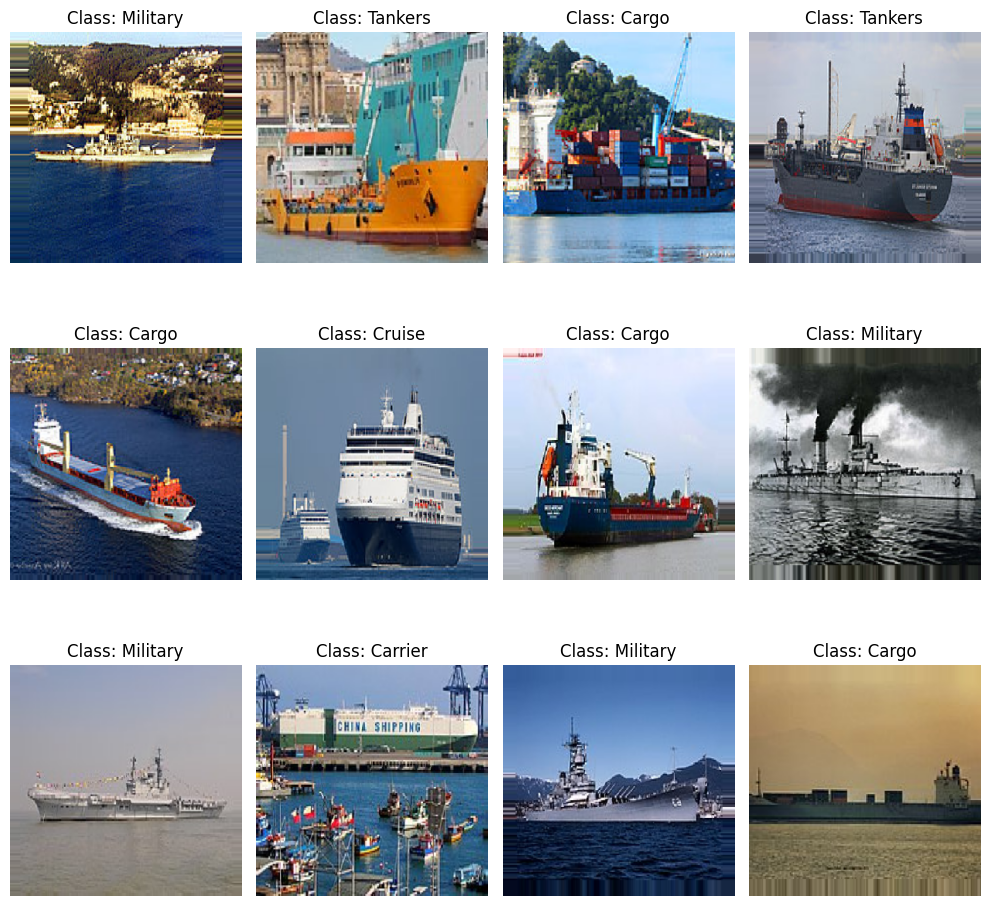

In [22]:
plot_images_in_grid(valid_batch, num_images=12, num_columns=4)


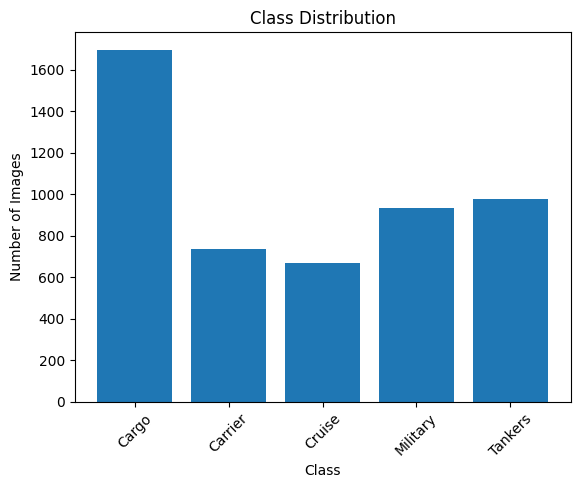

In [23]:
import matplotlib.pyplot as plt

# Count the number of images in each class
class_counts = train_batch.classes

# Get class labels from the generator
class_labels = list(train_batch.class_indices.keys())

# Plot a bar chart showing the class distribution
plt.bar(class_labels, [sum(class_counts == i) for i in range(len(class_labels))])
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.show()


In [24]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [25]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(300, 300, 3))


80134624/80134624 [==============================] - 1s 0us/step


In [26]:
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(5, activation='softmax')(x)  


In [27]:
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [29]:
history = model.fit(train_batch,
                    steps_per_epoch=len(train_batch),
                    epochs=12,
                    validation_data=valid_batch,
                    validation_steps=len(valid_batch))

Epoch 1/12
79/79 [==============================] - 186s 2s/step - loss: 1.2540 - accuracy: 0.5607 - val_loss: 0.6341 - val_accuracy: 0.7510
Epoch 2/12
79/79 [==============================] - 163s 2s/step - loss: 0.5388 - accuracy: 0.7943 - val_loss: 0.5363 - val_accuracy: 0.7902
Epoch 3/12
79/79 [==============================] - 152s 2s/step - loss: 0.4042 - accuracy: 0.8393 - val_loss: 0.4882 - val_accuracy: 0.8062
Epoch 4/12
79/79 [==============================] - 151s 2s/step - loss: 0.4007 - accuracy: 0.8393 - val_loss: 0.5116 - val_accuracy: 0.8070
Epoch 5/12
79/79 [==============================] - 152s 2s/step - loss: 0.3065 - accuracy: 0.8795 - val_loss: 0.6296 - val_accuracy: 0.7518
Epoch 6/12
79/79 [==============================] - 151s 2s/step - loss: 0.2896 - accuracy: 0.8851 - val_loss: 0.5136 - val_accuracy: 0.8151
Epoch 7/12
79/79 [==============================] - 151s 2s/step - loss: 0.2220 - accuracy: 0.9157 - val_loss: 0.5521 - val_accuracy: 0.7966
Epoch 8/12
79

In [33]:
validation_loss, validation_accuracy = model.evaluate(valid_batch)
print("Validation Accuracy:", validation_accuracy)


20/20 [==============================] - 30s 1s/step - loss: 0.4808 - accuracy: 0.8399
Validation Accuracy: 0.839871883392334


In [31]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Define your class labels
class_labels = ['Cargo', 'Carrier', 'Cruise', 'Military','Tankers']  # Update with your actual class labels

# Load and preprocess the image
img = image.load_img('/content/Dataset/Cruise/1004028.jpg', target_size=(300, 300))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension

# Make predictions
predictions = model.predict(img_array)  # Assuming 'model' is your trained VGG19 model
# Get the class with the highest probability
predicted_class_index = np.argmax(predictions)
# Get the predicted class label
predicted_class = class_labels[predicted_class_index]
print("Predicted class:", predicted_class)


# Load and preprocess the image
img = image.load_img('/content/Dataset/Tankers/2845727.jpg', target_size=(300, 300))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension

# Make predictions
predictions = model.predict(img_array)  # Assuming 'model' is your trained VGG19 model
# Get the class with the highest probability
predicted_class_index = np.argmax(predictions)
# Get the predicted class label
predicted_class = class_labels[predicted_class_index]
print("Predicted class:", predicted_class)


1/1 [==============================] - 1s 908ms/step
Predicted class: Cruise
1/1 [==============================] - 0s 31ms/step
Predicted class: Tankers


In [32]:
import pickle

# Save the trained model to a file using pickle
with open('trained_model2.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)